**Load Dataset**

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
zip_train = zipfile.ZipFile('/content/train.zip', 'r')
zip_train.extractall('/content/train')
zip_train.close()

In [5]:
zip_test = zipfile.ZipFile('/content/test1.zip', 'r')
zip_test.extractall('/content/test1')
zip_test.close()

In [6]:
import os

os.makedirs("/content/train/cat", exist_ok=True)
os.makedirs("/content/train/dog", exist_ok=True)

In [7]:
import shutil

src = "/content/train/train"   # actual images
dst_cat = "/content/train/cat"
dst_dog = "/content/train/dog"

In [8]:
for filename in os.listdir(src):
    full_path = f"{src}/{filename}"

    if filename.startswith("cat"):
        shutil.move(full_path, f"{dst_cat}/{filename}")
    elif filename.startswith("dog"):
        shutil.move(full_path, f"{dst_dog}/{filename}")

In [9]:
import os
print(os.listdir("/content/train/cat"))
print(os.listdir("/content/train/train"))
print(os.listdir("/content/train/dog"))

['cat.9422.jpg', 'cat.11039.jpg', 'cat.940.jpg', 'cat.10495.jpg', 'cat.5520.jpg', 'cat.1993.jpg', 'cat.5308.jpg', 'cat.3113.jpg', 'cat.10471.jpg', 'cat.9089.jpg', 'cat.6290.jpg', 'cat.10022.jpg', 'cat.2882.jpg', 'cat.6052.jpg', 'cat.3600.jpg', 'cat.2628.jpg', 'cat.2592.jpg', 'cat.10519.jpg', 'cat.7077.jpg', 'cat.1736.jpg', 'cat.479.jpg', 'cat.2638.jpg', 'cat.10341.jpg', 'cat.7392.jpg', 'cat.5895.jpg', 'cat.10103.jpg', 'cat.9207.jpg', 'cat.12211.jpg', 'cat.749.jpg', 'cat.8140.jpg', 'cat.1465.jpg', 'cat.11526.jpg', 'cat.10295.jpg', 'cat.1336.jpg', 'cat.1467.jpg', 'cat.5202.jpg', 'cat.2960.jpg', 'cat.10364.jpg', 'cat.6397.jpg', 'cat.12406.jpg', 'cat.1555.jpg', 'cat.7566.jpg', 'cat.2915.jpg', 'cat.8982.jpg', 'cat.643.jpg', 'cat.7743.jpg', 'cat.6841.jpg', 'cat.9217.jpg', 'cat.10909.jpg', 'cat.218.jpg', 'cat.447.jpg', 'cat.2364.jpg', 'cat.7626.jpg', 'cat.869.jpg', 'cat.12009.jpg', 'cat.904.jpg', 'cat.4369.jpg', 'cat.7745.jpg', 'cat.5174.jpg', 'cat.10489.jpg', 'cat.7417.jpg', 'cat.5747.jpg', 

In [10]:
shutil.rmtree("/content/train/train")

In [11]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

In [12]:
# generators

train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256, 256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test1',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256, 256)
)

Found 25000 files belonging to 2 classes.
Found 12500 files belonging to 1 classes.


In [13]:
# normalize

def process(image, label):
    image = tf.cast(image/255. ,tf.float32)
    return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [14]:
# create CNN model

model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 106s 121ms/step - accuracy: 0.5534 - loss: 2.7871 - val_accuracy: 0.7133 - val_loss: 1.0260
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 86s 110ms/step - accuracy: 0.6132 - loss: 0.6457 - val_accuracy: 0.7287 - val_loss: 0.9338
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 85s 108ms/step - accuracy: 0.7154 - loss: 0.5452 - val_accuracy: 0.5074 - val_loss: 1.1509
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - accuracy: 0.7754 - loss: 0.4533 - val_accuracy: 0.3255 - val_loss: 2.1211
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 77s 99ms/step - accuracy: 0.8078 - loss: 0.3948 - val_accuracy: 0.5155 - val_loss: 1.5020
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 77s 98ms/step - accuracy: 0.8391 - loss: 0.3360 - val_accuracy: 0.7597 - val_loss: 0.7749
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 77s 98ms/step - accuracy: 0.8591 - loss: 0.2856 - val_accuracy: 0.7684 - val_loss: 1.1196
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 77s 98ms/step - accuracy: 0.8904 - loss: 0.23

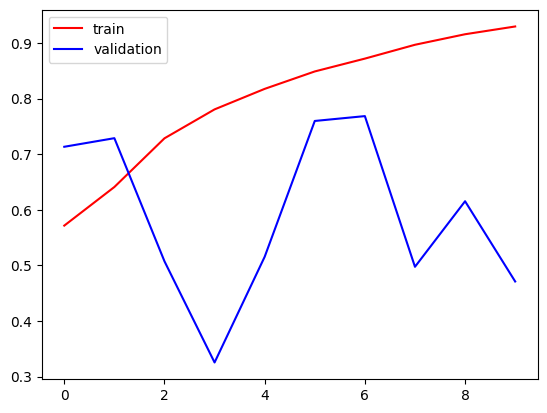

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], color='red', label='train')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

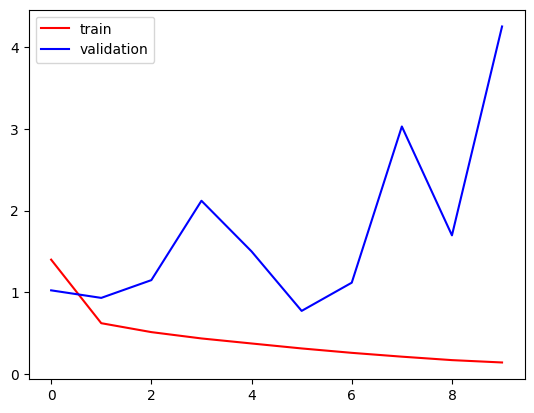

In [19]:
plt.plot(history.history['loss'], color='red', label='train')
plt.plot(history.history['val_loss'], color='blue', label='validation')
plt.legend()
plt.show()

In [20]:
import cv2

In [24]:
test_img1 =cv2.imread("/content/012.jpeg")

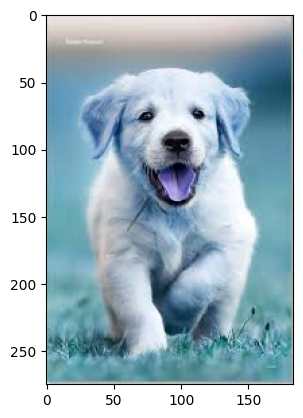

In [25]:
plt.imshow(test_img1)

In [26]:
test_img1.shape

(275, 184, 3)

In [27]:
test_img1 = cv2.resize(test_img1, (256,256))

In [28]:
test_input1 = test_img1.reshape((1,256,256,3))

In [29]:
model.predict(test_input1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[1.]], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


array([[1.]], dtype=float32)

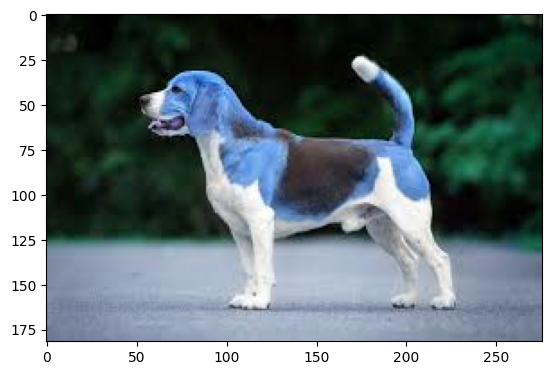

In [33]:
test_img2 =cv2.imread("/content/013.jpeg")
plt.imshow(test_img2)
test_img2.shape
test_img2 = cv2.resize(test_img2, (256,256))
test_input2 = test_img2.reshape((1,256,256,3))
model.predict(test_input2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([[0.]], dtype=float32)

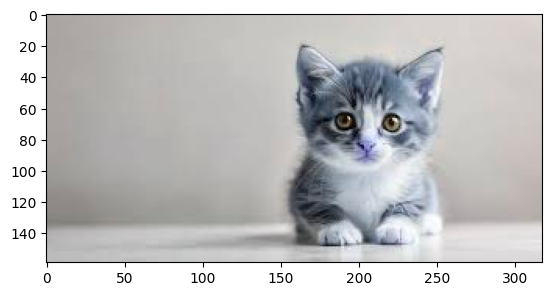

In [34]:
test_img3 =cv2.imread("/content/014.jpeg")
plt.imshow(test_img3)
test_img3.shape
test_img3 = cv2.resize(test_img3, (256,256))
test_input3 = test_img3.reshape((1,256,256,3))
model.predict(test_input3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


array([[2.1391286e-23]], dtype=float32)

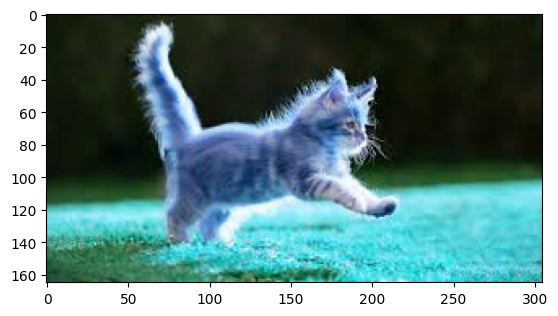

In [35]:
test_img4 =cv2.imread("/content/015.jpeg")
plt.imshow(test_img4)
test_img4.shape
test_img4 = cv2.resize(test_img4, (256,256))
test_input4 = test_img4.reshape((1,256,256,3))
model.predict(test_input4)